In [1]:
import sys
sys.path.extend(['..', '../bprime'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [35]:
import os
import pickle
import operator
from collections import defaultdict
import tqdm
import tskit
import numpy as np
import pyslim
import scipy.stats as stats
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl

from bprime.tree_utils import load_recrates, load_neutregions
from bprime.models import BGSModel 
from bprime.utils import load_bed_annotation, load_seqlens, RecMap, midpoint, arg_nearest
from bprime.utils import read_bkgd

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')


In [4]:
force = True

### bgspy B maps

In [5]:
annot = load_bed_annotation(f"../data/annotation/conserved_by_chrom/chr10.bed")
seqlens = load_seqlens("../data/annotation/hg38_seqlens.tsv")
recmap = RecMap("../data/annotation/hapmap/genetic_map_GRCh37_chr10.txt", seqlens=seqlens, conversion_factor=1e-8)

m = BGSModel(recmap, annot,
             seqlens={'chr10': seqlens['chr10']}, 
             w_grid=np.array([1e-7, 5e-7, 1e-8, 1e-9]),
             t_grid=np.array([0.1, 0.01, 0.001, 0.0001]))

pkl_b_file = '../data/bmaps/bgspy/B_chr10.pkl'


if force or not os.path.exists(pkl_b_file):
    m.calc_B(step=1_000, ncores=70, nchunks=70)
    m.save_B(pkl_b_file)   
else:
    m.load_B(pkl_b_file)

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
completed segmenting chr10.
looking up map positions...	done.
pre-computing segment contributions...	done.
Genome divided into 70 chunks to be processed on 70 CPUs...


/home/vsb/projects/bprime/notebooks/../bprime/utils.py:441: UserWarning: some positions [133798000] are greater than sequence length (133797422
  warnings.warn(msg)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [02:22<00:00,  2.03s/it]


### `calc_bkgd` maps

In [6]:
bkgd_dir = '../data/bmaps/calc_bkgd/'
cached_bkgd_file = os.path.join(bkgd_dir, "calc_bkgd_mu1e-8.pkl")

if force or not os.path.exists(cached_bkgd_file):
    bkgd_runs = [os.path.join(bkgd_dir, f) for f in os.listdir(bkgd_dir) if f.startswith('calc_bkgd_s')]

    def load_bkgd(run):
        files = os.listdir(run)
        bkgd = dict()
        for file in files:
            chrom = file.replace('.bkgd', '')
            try:
                bkgd[chrom] = read_bkgd(os.path.join(run, file))
            except ValueError:
                continue
                raise ValueError(f"parsing error at {run}/{file}")
        return bkgd

    bkgd = dict()
    for run in bkgd_runs:
        s = os.path.basename(run).replace('calc_bkgd_s', '')
        bkgd[float(s)] = load_bkgd(run)

    with open(cached_bkgd_file, 'wb') as f:
        pickle.dump(bkgd, f)
else:
    with open(cached_bkgd_file, 'rb') as f:
        bkgd = pickle.load(f)

### Simulation Results

In [7]:
DATADIR = '../data/slim_sims/bgsmap/'
tree_files = [os.path.join(DATADIR, f) for f in os.listdir(DATADIR) if f.endswith('.tree')]

In [8]:
len(tree_files)

500

In [9]:
def get_b(file, params, width=1000, recrate=1e-8, seed=None):
    "Recapitate trees and calc B"
    ts = pyslim.load(file)
    md = ts.metadata['SLiM']['user_metadata']
    region_length = md['region_length'][0]
    N = md['N'][0]
    #recmap = load_recrates('../data/annotation/rec_100kb_chr10.bed', ts.sequence_length)
    rts = pyslim.recapitate(ts, recombination_rate=recrate, sequence_length=ts.sequence_length,
                            ancestral_Ne=N, random_seed=seed)
    length = int(ts.sequence_length)
    neut_positions = np.linspace(0, length, length // width).astype(int)
    params = {k: md[k][0] for k in params}
    return tuple(params.items()), neut_positions, rts.diversity(mode='branch', windows=neut_positions) / (4*N)



In [10]:
cached_bgsmap_file = '../data/bmaps/bgsmap_sims.pkl'

if force or not os.path.exists(cached_bkgd_file):
    sims = defaultdict(list)

    for file in tqdm.tqdm(tree_files):
        params, pos, b = get_b(file, ('s', 'mu'))
        sims[params].append((pos, b))

    for key, res in sims.items():
        pos = list(map(operator.itemgetter(0), res))
        b = list(map(operator.itemgetter(1), res))
        sims[key] = np.stack(pos)[0, :], np.stack(b).T
    with open(cached_bgsmap_file, 'wb') as f:
        pickle.dump(sims, f)
else:
    with open(cached_bgsmap_file, 'rb') as f:
        sims = pickle.load(f)    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:48<00:00,  2.96it/s]


Text(0, 0.5, 'B')

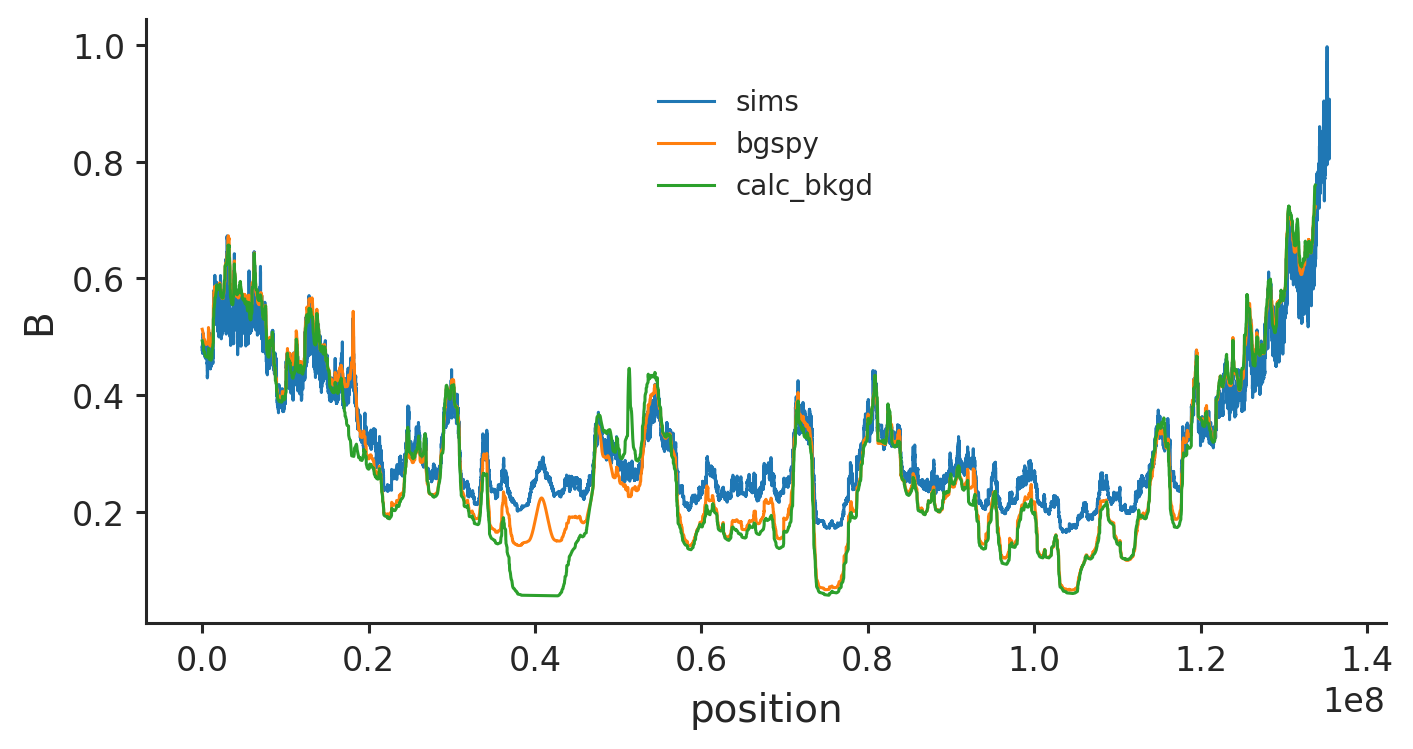

In [19]:
s, mu = 0.02, 1e-8
pos, b = sims[(('s', s), ('mu', mu))]

fig, ax = plt.subplots()
ax.plot(midpoint(pos), b.mean(axis=1), label="sims")
bgspy_b = m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]
ax.plot(m.BScores.pos['chr10'], np.exp(bgspy_b), label="bgspy")
ax.plot(bkgd[s/2]['chr10'][0], bkgd[s/2]['chr10'][1], label="calc_bkgd")
ax.legend(loc='upper center')
ax.set_xlabel('position')
ax.set_ylabel('B')

In [20]:
binterpols = m.BScores_interpolater(0)

In [40]:
dir(lh)

['_A',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_animated',
 '_antialiaseds',
 '_axes',
 '_bcast_lwls',
 '_callbacks',
 '_capstyle',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_default_contains',
 '_edge_default',
 '_edge_is_mapped',
 '_edgecolors',
 '_face_is_mapped',
 '_facecolors',
 '_factor',
 '_get_clipping_extent_bbox',
 '_get_default_antialiased',
 '_get_default_edgecolor',
 '_get_default_facecolor',
 '_get_default_linewidth',
 '_gid',
 '_hatch',
 '_hatch_color',
 '_id_norm',
 '_in_layout',
 '_joinstyle',
 '_label',
 '_linestyles',
 '_linewidths',
 '_mapped_colors',

(0.0, 0.8)

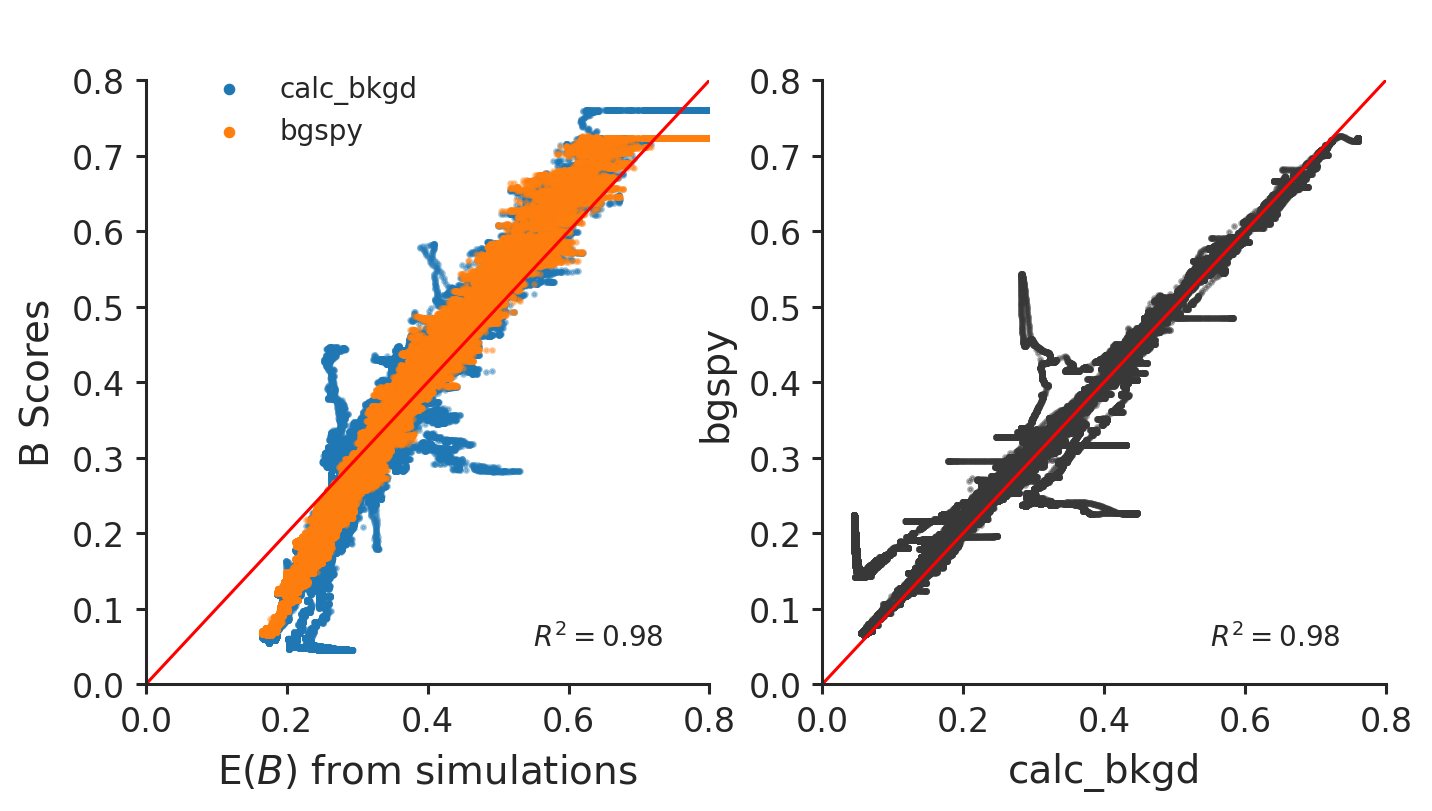

In [44]:
fig, ax = plt.subplots(ncols = 2)
x = b.mean(axis=1)
y = np.exp(binterpols['chr10'][(1e-8, 1e-2)](midpoint(pos)))
bkgd_y = bkgd[s/2]['chr10'][1]
bkgd_func = interpolate.interp1d(bkgd[s/2]['chr10'][0], bkgd_y, fill_value=(bkgd_y[0], bkgd_y[-1]), bounds_error=False, kind='quadratic')
z = bkgd_func(midpoint(pos))

ax[0].scatter(x, z, s=2, alpha=0.4, label='calc_bkgd')
ax[0].scatter(x, y, s=2, alpha=0.4, label='bgspy')
ax[0].text(0.55, 0.05, f"$R^2 = {np.round(np.corrcoef(x, y)[0, 1], 2)}$")
ax[0].axline((0.1, 0.1), slope=1, c='r')
ax[0].set_xlabel("$\mathrm{E}(B)$ from simulations")
ax[0].set_ylabel("B Scores")
ax[0].set_xlim((0, 0.8))
ax[0].set_ylim((0, 0.8))
leg = ax[0].legend(loc=(0, 0.8))
for lh in leg.legendHandles:
    lh.set_alpha(1)
    lh.set_sizes([10] * len(lh.get_sizes()))

#ax[1].scatter(z, y, s=4, c=(x-z)/x, cmap='brg')
ax[1].scatter(z, y, s=2, c='0.22', alpha=0.4)
ax[1].text(0.55, 0.05, f"$R^2 = {np.round(np.corrcoef(z, y)[0, 1], 2)}$")
ax[1].axline((0, 0), slope=1, c='r')
ax[1].set_xlabel("calc_bkgd")
ax[1].set_ylabel("bgspy")
ax[1].set_xlim((0, 0.8))
ax[1].set_ylim((0, 0.8))


In [15]:
i = np.zeros(seqlens['chr10'])
for row in m.segments.ranges:
    i[slice(*row)] = 1

covered_bases = np.where(i)[0]

In [16]:
wins = np.linspace(0, seqlens['chr10'], seqlens['chr10'] // 1_000_000).astype(int)
coverage = stats.binned_statistic(covered_bases, np.full(len(covered_bases), 1), statistic=np.sum, bins=wins)

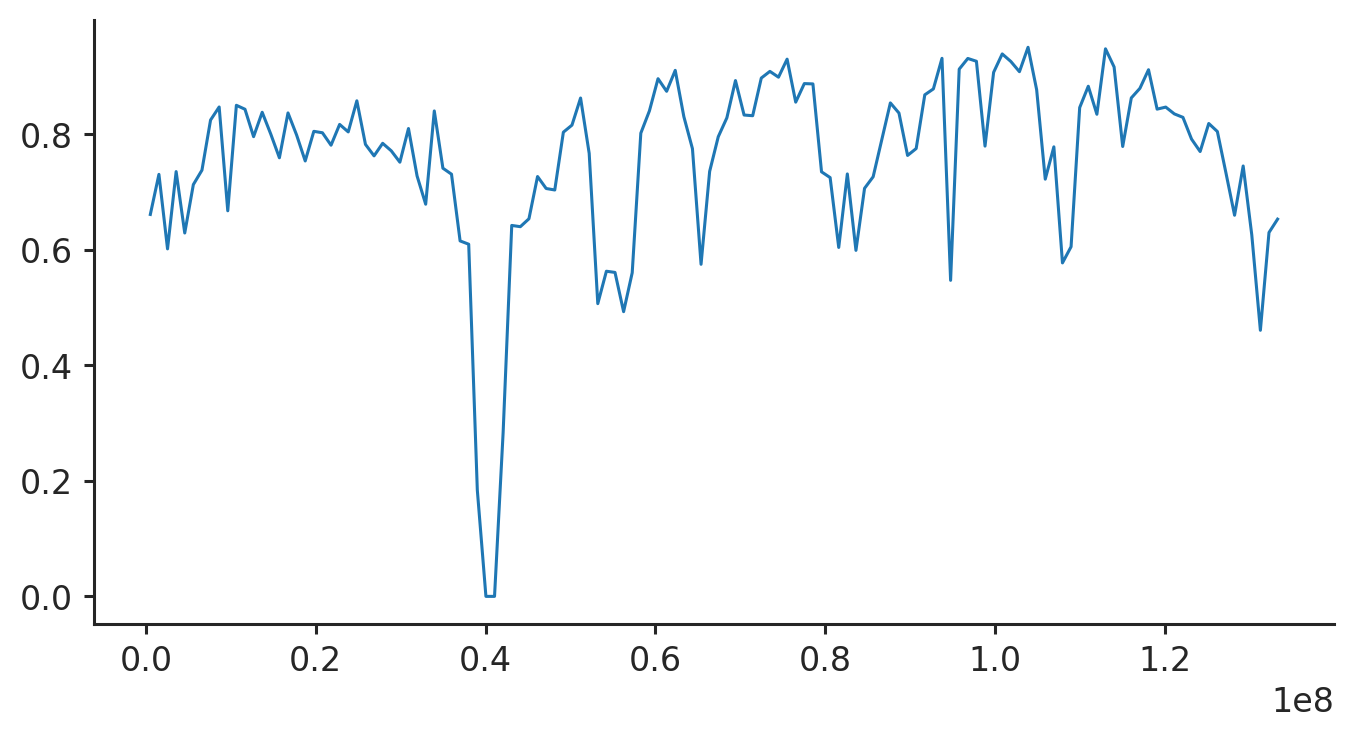

In [17]:
plt.plot(midpoint(coverage.bin_edges), coverage.statistic/1_000_000)

Text(0, 0.5, 'B')

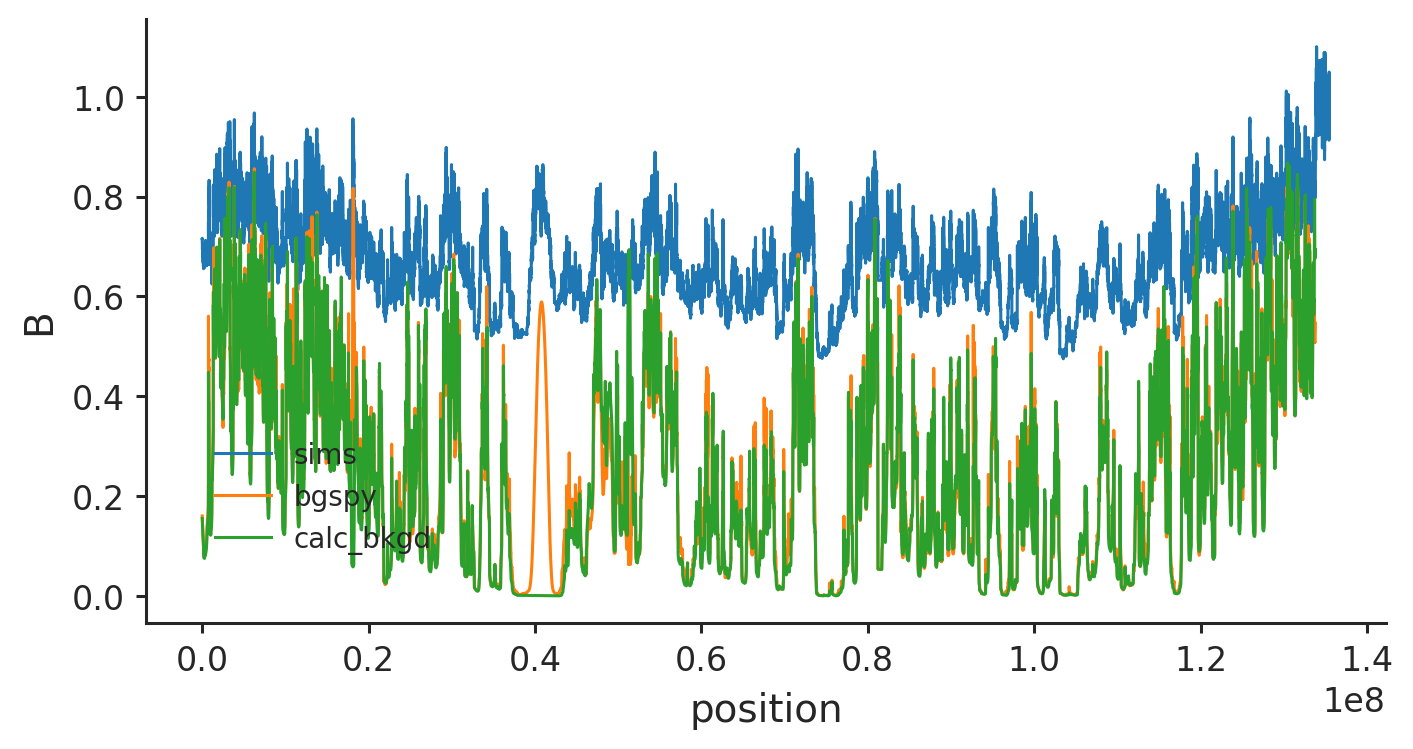

In [18]:
s, mu = 2e-3, 1e-8
pos, b = sims[(('s', s), ('mu', mu))]

fig, ax = plt.subplots()
ax.plot(midpoint(pos), b.mean(axis=1), label="sims")
bgspy_b = m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]
ax.plot(m.BScores.pos['chr10'], np.exp(bgspy_b), label="bgspy")
ax.plot(bkgd[s/2]['chr10'][0], bkgd[s/2]['chr10'][1], label="calc_bkgd")
ax.legend(loc='lower left')
#ax.axvline(0.375e8, c='red')
#ax.axvline(0.43e8, c='red')

ax.set_xlabel('position')
ax.set_ylabel('B')